# Mini Project Part B

This is a template for Part B of your project. It builds on Part A that you have solved earlier this term. 

You are provided with the code to
* load and prepare the data
* evaluate your classifiers
* train and evaluate a benchmark classifier

Your tasks are to
* implement two advanced classifiers using variety of techniques from **weeks 4-9** which may include dimensionality reduction, random forests, ensembles, feature selection and neural networks.
* analyse the performance of your classifiers and compare them to the benchmark classifier
* discover the most important features (brain connections) that drive differences between term and preterm babies

For each task you need to either write code in the 'Code' cell or answer the question in the 'Markdown' cell. There is a word limit to discourage lengthy commentaries. Be brief and clear.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load and prepare data

You already know this dataset from part A. However this time, the dataset has been split in advance into training and test set. The code below loads the **training dataset** for you. You will be given the test dataset at the end of the notebook.

(341, 90, 90)


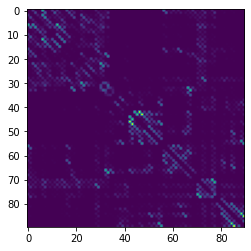

In [2]:
# load connectivity matrices
import pickle
matrices = pickle.load( open( "data/matrices_train.p", "rb" ) )
print(matrices.shape)
plt.imshow(matrices[1,:,:])

In [3]:
# convert upper triangles of the matrices to feature vectors

# dimensions
n = matrices.shape[0]
m = matrices.shape[1]
D = round(m*(m-1)/2)
print('n={}, D={}'.format(n,D))

# feature matrix
X=np.zeros([n,D])
for i in range(n):
    index=0
    for j in range(m):
        for k in range(j):
            X[i,index]=matrices[i,j,k]
            index=index+1
print(X.shape)

n=341, D=4005
(341, 4005)


In [4]:
# load subject info
subject_info = pd.read_csv('data/subject_info_train.csv')
subject_info

,age,prematurity
0,39,1
1,41,1
2,41,1
3,41,1
4,44,1
...,...,...
336,43,0
337,44,0
338,44,0
339,44,0


In [5]:
# load gray matter region descriptions - you will need this in for discovery of important discriminative features
label_names = pd.read_csv('data/label_names.csv')
label_names

,Label,Region name,Region description
0,1.0,Precentral_L,Precental gyrus
1,2.0,Precentral_R,Precental gyrus
2,3.0,Frontal_Sup_L,"Superior frontal gyrus, dorsolateral"
3,4.0,Frontal_Sup_R,"Superior frontal gyrus, dorsolateral"
4,5.0,Frontal_Sup_Orb_L,"Superior frontal gyrus, orbital part"
...,...,...,...
85,86.0,Temporal_Mid_R,Middle temporal gyrus
86,87.0,Temporal_Pole_Mid_L,Temporal pole: middle temporal gyrus
87,88.0,Temporal_Pole_Mid_R,Temporal pole: middle temporal gyrus
88,89.0,Temporal_Inf_L,Inferior temporal gyrus


Prepare the feature matrix and label vector

In [7]:
# Preprocessing

from sklearn.preprocessing import StandardScaler

# Use feature matrix X and scale the features
X = StandardScaler().fit_transform(X)

# Extract label vector
y = subject_info.to_numpy()[:,1]

## Evaluation framework

In [7]:
# Evaluation using predicted labels
# use to calculate training and test performance
# also validation performance when we have a single validation set (e.g. neural networks)
# can be used for sklearn and torch (make sure y_pred is converted to numpy or tensors with no gradients)

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

def evaluation(y,y_pred):
    # accuracy
    accuracy = accuracy_score(y,y_pred)
    print('accuracy: ', round(accuracy,2))
    # sensitivity: pos_label = 1
    sensitivity = recall_score(y,y_pred)
    print('sensitivity: ',round(sensitivity,2))
    # pos_label = 0 gives specificity
    specificity = recall_score(y,y_pred,pos_label = 0)
    print('specificity: ',round(specificity,2))
    # average recall 
    mean_recall = recall_score(y,y_pred,average='macro')
    print('mean recall: ',round(mean_recall,2))

In [8]:
# Evaluation using cross-validation
# use to calculate cross-validated performance on training set
# never use on test set
# only compatible with sklearn but not torch

from sklearn.model_selection import cross_val_predict


def evaluationCV(model,X,y):

    # predict using cross-validation
    y_pred = cross_val_predict(model,X,y)

    # accuracy
    accuracy = accuracy_score(y,y_pred)
    print('CV accuracy: ', round(accuracy,2))    
    # sensitivity: pos_label = 1
    sensitivity = recall_score(y,y_pred)
    print('CV sensitivity: ',round(sensitivity,2))
    # pos_label = 0 gives specificity
    specificity = recall_score(y,y_pred,pos_label = 0)
    print('CV specificity: ',round(specificity,2))
    # average recall
    mean_recall = recall_score(y,y_pred,average='macro')
    print('CV mean recall: ',round(mean_recall,2))    

## Benchmark classifier

We train a simple **logistic regression classifier** as our benchmark model, to compare performance of the advanced models. This classifier
* deals with the problem of large number of features (4005) compared to the small number of training samples (341) by using __ridge regularisation__
* tunes regularisation parameter `C` using __cross-validated accuracy__
* does not address the data imbalance

In [9]:
# Train Logistic regression classifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
param_grid = {"C": np.logspace(-3, 3, 13)}
grid_search = GridSearchCV(model, cv=5, param_grid=param_grid) 
_=grid_search.fit(X,y) 

print('Best C  :', grid_search.best_estimator_.C) 
print('Best CV accuracy:', round(grid_search.best_score_,2))

# best model
classifier_benchmark = grid_search.best_estimator_

Best C  : 10.0
Best CV accuracy: 0.91


In [10]:
print('Training performance:')
y_pred = classifier_benchmark.predict(X)
evaluation(y,y_pred)

Training performance:
accuracy:  1.0
sensitivity:  1.0
specificity:  1.0
mean recall:  1.0


In [11]:
print('Cross-validated performance on training set:')
evaluationCV(classifier_benchmark,X,y)

Cross-validated performance on training set:
CV accuracy:  0.91
CV sensitivity:  0.66
CV specificity:  0.97
CV mean recall:  0.81


**Analysis of the performance:**
* Training performance is very high, and much higher than CV performance, we see that the model still **overfits** the data
* CV accuracy is good (91%), however we have **low sensitivity**, probably due to data imballance and overlap between two classes


## 1. Your Classifier 1

**30 marks**

**Task 1.1:** Train and tune your first advanced classifier. Make sure you print out any tuned parameters.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# Feature Selection
k=20
selector_1 = SelectKBest(mutual_info_classif, k = k)
X_selected = selector_1.fit_transform(X,y)
print('Shape of the new matrix: ', X_selected.shape)
ind = np.where(selector_1.get_support())[0]
print('Indices: ', ind)

# Create and train classifier 1
pipe = Pipeline(steps=[('SGDC_model', SGDClassifier(max_iter=150000, class_weight='balanced'))])

param_grid = {'SGDC_model__penalty': ['l2', 'l1'],
              'SGDC_model__alpha': np.logspace(-3, 3, 7)}

g = GridSearchCV(estimator=pipe, param_grid=param_grid)
g.fit(X_selected,y) 


# Print best CV metric and tuned parameters
print('Best Params:', g.best_params_) 
print('Best CV accuracy:', round(g.best_score_,2))

# save your best model 1
classifier1 = g.best_estimator_

Shape of the new matrix:  (341, 20)
Indices:  [  17  174 1075 1852 2109 2450 2485 2541 2597 2622 2689 2723 2751 2771
 2851 2869 2919 2920 2926 3992]
Best Params: {'SGDC_model__alpha': 1.0, 'SGDC_model__penalty': 'l2'}
Best CV accuracy: 0.87


**Task 1.2: Describe the main features of your classifier and how they address the challenges of overfitting, class imbalance and class overlap [max 100 words]:**

Feature selection (20 features) was used to avoid overfitting by significantly reducing the number of features. Fot this, Mutual Information technique was used. To avoid the problem of class imbalance a SGDClassifier was created with the parameter class_weight set to 'balanced'. Also, a gridsearch with cross validation was used to obtain the best parameters (alpha and penalty) of the SGD Classifier.

Run the cell to evaluate **training performance** of your classifier:

*Note: You need to amend this if using Pytorch*

In [15]:
y_pred = classifier1.predict(X_selected)
evaluation(y,y_pred)

accuracy:  0.88
sensitivity:  0.84
specificity:  0.89
mean recall:  0.87


Run the cell to evaluate **CV performance** of your classifier:

*Note: You need to amend this if using Pytorch*

In [16]:
evaluationCV(classifier1,X_selected,y)

CV accuracy:  0.86
CV sensitivity:  0.84
CV specificity:  0.87
CV mean recall:  0.85


**Task 1.3: Analyse performance of your new classifier and compare it to the benchmark classifier [max 50 words]:**
There is a slight difference between evaluation and evaluationCV, but this classifier is not overfitted as the benchmark one. CV Accuracy is a bit less, but due to class imbalance is not very relevant. Sensitivity and mean recall in evaluation CV are better than in the benchamrk classifier.

## 2. Your Classifier 2

**30 marks**

**Task 2.1:** Train and tune your first advanced classifier. Make sure you print out any tuned parameters.

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import f_classif
from sklearn.svm import SVC

selector_2 = SelectKBest(f_classif, k=20)
X_selected = selector_2.fit_transform(X, y)
print('Selected Features: ', selector_2.get_support(indices=True))

# Create and train classifier 2
ABC = AdaBoostClassifier(base_estimator=SVC(kernel='rbf'), algorithm='SAMME')
param_grid = {'base_estimator__C': np.logspace(-3, 3, 7),
              'n_estimators': [2, 5, 10],
              'base_estimator__kernel': ['rbf', 'linear'],
              'base_estimator__degree': [1, 2, 3, 4]}

g = GridSearchCV(estimator=ABC, param_grid=param_grid)
g.fit(X_selected,y)

# Print best CV metric and tuned parameters
print('Best Params:', g.best_params_) 
print('Best CV accuracy:', round(g.best_score_,2))

# save your best model 2
classifier2 = g.best_estimator_

Selected Features:  [  17   24  174  615  616  627 1607 1859 1951 2109 2562 2689 2693 2707
 2723 2771 2775 2846 2926 2997]
Best Params: {'base_estimator__C': 10.0, 'base_estimator__degree': 1, 'base_estimator__kernel': 'linear', 'n_estimators': 2}
Best CV accuracy: 0.92


**Task 2.2: Describe the main features of your classifier and how they address the challenges of overfitting, class imbalance and class overlap [max 100 words]:**

For this classifier to avoid overfitting f_classification was used to reduce the number of features to 20. The Adaboost algorithm was used as well with a Support Vector Classifier where the parameter C, the type of kernel used, and the drgree (in case of linear kernel) was tuned. This algortihm was chosed as it helps to readjust the weight of training data prior to training each new weak learner to give higher weight to previously misclassified samples.

Run the cell to evaluate **training performance** of your classifier:

*Note: You need to amend this if using Pytorch*

In [19]:
y_pred = classifier2.predict(X_selected)
evaluation(y,y_pred)

accuracy:  0.93
sensitivity:  0.75
specificity:  0.97
mean recall:  0.86


Run the cell to evaluate **CV performance** of your classifier:

*Note: You need to amend this if using Pytorch*

In [20]:
evaluationCV(classifier2,X_selected,y)

CV accuracy:  0.92
CV sensitivity:  0.74
CV specificity:  0.96
CV mean recall:  0.85


**Task 2.3: Analyse performance of your new classifier 2 and compare it to the benchmark classifier [max 50 words]:**

In this classifier, both evaluationCV and evaluation throw similar accuracy, sensitivity, specificity, and mean recall results showing that overfitting is not an issue which was not the case of the benchmark classifier. Also, accuracy in both classifiers are similar, but this one offers better sensitivity.

**Task 2.4: Compare performance of your new classifier 2 your classifier 1 [max 50 words]:**

Both Classifier do not overfit to the data. Having said that, classifier 2 has a better CV accuracy, also specificity is better in classifier 2 while sensitivity is better in classifier 1, however, both of them have the same score for mean recall.

## 3. Analyse the results

### Discover the most predictive features
**10 marks**

**Task 3.1:** Print out most predictive features of at least one of your models.

In [10]:
# Identify and print the most important predictive features

print('Selected Features indices for classifier 2 (the better model): ', selector_2.get_support(indices=True))
print("")

print('Most relevant connections chosen using classifier 2:')
features_names = []
j = 0
for i in range(0, 90):
    while ((j <= len(label_names)) and (j != i)):
        f_name = label_names['Region name'].iloc[i]+ " + " + label_names['Region name'].iloc[j]
        features_names.append(f_name)
        j += 1
    j = 0
        
print(len(features_names))
for i in range(len(selector_2.get_support(indices=True))):
    print(features_names[selector_2.get_support(indices=True)[i]])

Selected Features indices for classifier 2 (the better model):  [  17   24  174  615  616  627 1607 1859 1951 2109 2562 2689 2693 2707
 2723 2771 2775 2846 2926 2997]

Most relevant connections chosen using classifier 2:
4005
Frontal_Mid_L  + Frontal_Sup_L 
Frontal_Mid_R  + Frontal_Sup_R 
Supp_Motor_Area_R  + Frontal_Sup_R 
Cingulum_Post_R  + Olfactory_L 
Cingulum_Post_R  + Olfactory_R 
Cingulum_Post_R  + Cingulum_Mid_L 
Postcentral_R  + Frontal_Inf_Oper_R 
Parietal_Inf_R  + Insula_R 
SupraMarginal_L  + Parietal_Inf_L 
Angular_R  + Insula_R 
Putamen_L  + Frontal_Mid_L 
Putamen_R  + Parietal_Inf_R 
Putamen_R  + Angular_R 
Pallidum_L  + Frontal_Mid_L 
Pallidum_L  + Frontal_Sup_Medial_L 
Pallidum_L  + Caudate_L 
Pallidum_R  + Precentral_L
Pallidum_R  + Caudate_R 
Thalamus_R  + Precentral_L
Thalamus_R  + Caudate_R 


### Plot the results
**15 marks**

**Task 3.2:** Demonstrate the fit using your best performing classifier(s). For example, you can use PCA to display results, but you can also come up with an original technique that we have not used before.

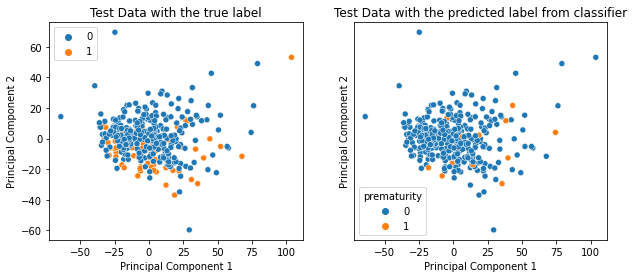

In [22]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec

# PCA with 2 principal components
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

# Plot the results

# Create Figure with 2 axes
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1,2)


# Axis 1: Test Data with true label
ax1 = plt.subplot(gs[0,0])
sns.scatterplot(x=pca_results[:,0], y=pca_results[:,1], hue=y)
plt.title('Test Data with the true label')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

# Axis 2: Test Data with predicted label
ax2 = plt.subplot(gs[0,1])
sns.scatterplot(x=pca_results[:,0], y=pca_results[:,1], hue=classifier2.predict(selector_1.transform(X)))
plt.title('Test Data with the predicted label from classifier')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_yticks([], [])
ax2.legend(title='prematurity')
plt.show()

**Task 3.3: Interpret your plots [max 50 words]:**
The results were plotted using classifier 2 which was the best classifier with an CV accuracy of 0.92. As it can be seen, the classifier predicts very well the training data with the exception of only a few data points, for example, the one at the top right of the plots.


## 4. Evaluate on the test set
**15 marks**

Finally, we will evaluate performance of our classifiers on the test set. The cell below loads the test set for you.

*Note: You are not allowed to use the test set anywhere else except for this section*

In [23]:
# load connectivity matrices
import pickle
matrices_test = pickle.load( open( "data/matrices_test.p", "rb" ) )

# convert upper triangles of the matrices to feature vectors
n = matrices_test.shape[0]
m = matrices_test.shape[1]
D = round(m*(m-1)/2)
X_test=np.zeros([n,D])
for i in range(n):
    index=0
    for j in range(m):
        for k in range(j):
            X_test[i,index]=matrices_test[i,j,k]
            index=index+1

# load subject info
subject_info_test = pd.read_csv('data/subject_info_test.csv')


# Preprocessing
from sklearn.preprocessing import StandardScaler
X_test = StandardScaler().fit_transform(X_test)
y_test = subject_info_test.to_numpy()[:,1]
print('X_test: ',X_test.shape)
print('y_test: ', y_test.shape)

X_test:  (92, 4005)
y_test:  (92,)


Run the cell below to evaluate performance of the **benchmark classifier**.

In [24]:
y_pred_test_benchmark = classifier_benchmark.predict(X_test)
evaluation(y_test,y_pred_test_benchmark)

accuracy:  0.89
sensitivity:  0.68
specificity:  0.95
mean recall:  0.81


**Task 4.1:** Evaluate performance of **your classifier 1** on the test set

In [26]:
y_pred_test_1 = classifier1.predict(selector_1.transform(X_test))
evaluation(y_test,y_pred_test_1)


accuracy:  0.86
sensitivity:  0.74
specificity:  0.89
mean recall:  0.81


**Task 4.2:** Evaluate performance of **your classifier 2** on the test set

In [27]:
y_pred_test_2 = classifier2.predict(selector_2.transform(X_test))
evaluation(y_test,y_pred_test_2)

accuracy:  0.92
sensitivity:  0.68
specificity:  0.99
mean recall:  0.84


**Task 4.3: Analyse performance of your classifiers on the test set and recommend the best technique [max 100 words]:**

**Classifier 1:** Same accuracy as the CV one calculated during training which is a good sign as it shows that the model did not overfit the data. However, sensitivity, specificity, and mean recall are slightly different from the ones obtained at training, but not by much, so it's a good classifier.

**classifier 2:** also matches the CV accuracy from training, which is a good sign of not overfitting. However, sensitivity (proportion of correctly classified positive samples) is a bit lower. 

**Recommendation:** use classifier 1 (even though that accuracy is less, it does not matter much as the dataset is imbalanced)
